In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [2]:
# import all from /raw_data/
# TODO concat all files in /raw_data/ into one dataframe
all_acc_csvs = glob.glob(os.getcwd() + "/raw_data/accelerometer/*.csv")
all_gyro_csvs = glob.glob(os.getcwd() + "/raw_data/gyroscope/*.csv")

df_acc = pd.concat([pd.read_csv(filename, index_col=None, header=0) 
            for filename in all_acc_csvs], axis=0, ignore_index=True)

df_gyro = pd.concat([pd.read_csv(filename, index_col=None, header=0) 
            for filename in all_gyro_csvs], axis=0, ignore_index=True)

In [3]:
# Cut off the readings when one sensor is started before the other
print(df_acc.shape, df_gyro.shape)

if df_acc.shape[0] > df_gyro.shape[0]:
    df_acc = df_acc.iloc[df_acc.shape[0] - df_gyro.shape[0]:, :]
else:
    df_gyro = df_gyro.iloc[df_gyro.shape[0] - df_acc.shape[0]:, :]

print(df_acc.shape, df_gyro.shape)

(8900, 7) (8531, 7)
(8531, 7) (8531, 7)


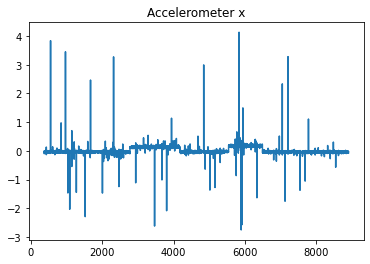

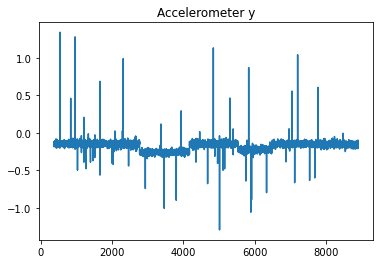

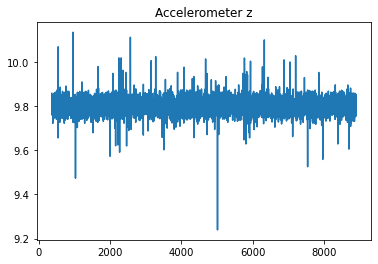

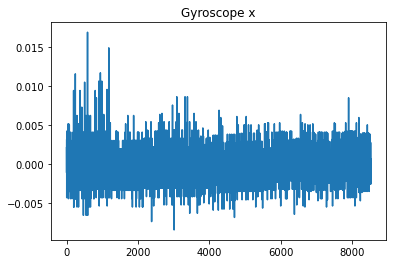

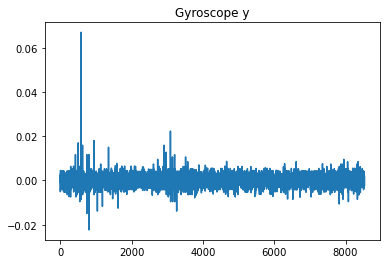

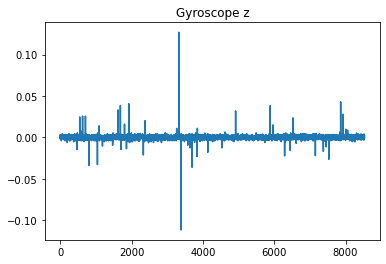

In [4]:
for df, name in zip([df_acc, df_gyro], ["Accelerometer", "Gyroscope"]):
    plt.plot(df["x"])
    plt.title(name + " x")
    plt.show()
    plt.plot(df["y"])
    plt.title(name + " y")
    plt.show()
    plt.plot(df["z"])
    plt.title(name + " z")
    plt.show()

In [5]:
current_payload = None
payload_change_indices = []
y_final_payload = []
print("Payload: ", end="")
for index, reading in enumerate(df_acc.values):
    if reading[6] != current_payload:
        current_payload = reading[6]
        added_symbol = str(current_payload[-1]) if str(current_payload) != 'nan' else None
        
        if added_symbol is not None:
            payload_change_indices.append(index)
            y_final_payload.append(added_symbol)
            print(added_symbol, end='')

print("\n", "# of readings:", len(df_acc.values))
print(" # of payload changes:", len(payload_change_indices))
print(" Payload change indices:", payload_change_indices)

Payload: defghijklmnopqrstuvwxyzAbcdefghijklmnopqrstuvwxyzAbcdefghijklmnopqrstuvwxyzAbcdefghijklmnopqrstuvwxyzHello World!WahooAbcdefghijklmnopqrstuvwxyz
 # of readings: 8531
 # of payload changes: 144
 Payload change indices: [0, 4, 66, 127, 186, 244, 307, 366, 425, 481, 546, 605, 664, 723, 784, 850, 909, 975, 1037, 1104, 1158, 1228, 1299, 1638, 1666, 1692, 1718, 1743, 1768, 1793, 1816, 1837, 1860, 1882, 1903, 1926, 1949, 1971, 1995, 2030, 2054, 2079, 2100, 2119, 2141, 2161, 2186, 2206, 2226, 2569, 2615, 2657, 2700, 2745, 2788, 2834, 2877, 2916, 2961, 3009, 3054, 3099, 3142, 3189, 3247, 3306, 3351, 3394, 3435, 3480, 3529, 3574, 3621, 3662, 3709, 3943, 3986, 4046, 4093, 4139, 4180, 4222, 4275, 4316, 4353, 4394, 4436, 4476, 4516, 4554, 4595, 4650, 4682, 4720, 4749, 4794, 4837, 4891, 4938, 4984, 5031, 5337, 5359, 5378, 5384, 5401, 5422, 5467, 5487, 5508, 5527, 5548, 5594, 5906, 5920, 5938, 5958, 5967, 6280, 6356, 6437, 6514, 6596, 6681, 6757, 6839, 6913, 7003, 7086, 7175, 7243, 7320, 741

In [6]:
important_indices = []
X_sequences = []
N_SURROUNDING = 10
for index in payload_change_indices:
    X_sequences.append(range(index - N_SURROUNDING , index + N_SURROUNDING))
    for i in range(index - N_SURROUNDING , index + N_SURROUNDING):
        if i >= 0 and i < len(df_acc.values) and i < len(df_gyro.values) and not (i in important_indices):
            important_indices.append(i)

print("# of relevant readings:", len(important_indices))
print(important_indices)

# of relevant readings: 2815
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 595, 596, 597, 598, 599, 600, 601, 602, 603,

In [7]:
X = np.array(
    [np.hstack((df_acc.iloc[seq,[3,4,5]].values, df_gyro.iloc[seq,[3,4,5]].values)) for seq in X_sequences]
)
print("Sequence Rows:", X.shape)
y = np.array(y_final_payload).reshape(-1,1)
print("Payload:", y_final_payload)

Sequence Rows: (144, 20, 6)
Payload: ['d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'H', 'e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l', 'd', '!', 'W', 'a', 'h', 'o', 'o', 'A', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
# normalize the data?
# transformations?
print(X)
print(y)

[[[-3.23389620e-02 -1.25762627e-01  9.79271603e+00 -1.46473735e-03
    0.00000000e+00 -1.19842147e-03]
  [-3.71299163e-02 -9.70168784e-02  9.78792572e+00  2.79631675e-03
   -3.19579057e-03  1.99736911e-03]
  [-1.79660898e-02 -1.68881238e-01  9.83463669e+00  6.65789703e-04
   -2.13052705e-03 -1.19842147e-03]
  ...
  [-1.13785230e-02 -1.86847329e-01  9.79211712e+00  0.00000000e+00
    2.66315881e-04  2.39684293e-03]
  [-1.13785230e-02 -1.38937756e-01  9.79690838e+00  4.26105410e-03
   -7.98947643e-04  2.66315881e-04]
  [-4.07231338e-02 -1.48519665e-01  9.75917912e+00  2.13052705e-03
    4.52736998e-03 -7.98947643e-04]]

 [[-1.79660898e-02 -2.11999848e-01  9.85380077e+00  6.65789703e-04
    1.06526352e-03 -1.33157941e-04]
  [-4.19208743e-02 -1.40135497e-01  9.77834320e+00 -1.46473735e-03
    2.13052705e-03 -2.26368499e-03]
  [-1.79660898e-02 -1.30553573e-01  9.79271603e+00 -3.99473822e-04
   -1.06526352e-03 -1.19842147e-03]
  ...
  [-4.07231338e-02 -1.48519665e-01  9.75917912e+00  0.00000

In [9]:
# output to /processed_data/
np.save(os.getcwd() + "/processed_data/proc_X.npy", X)
np.save(os.getcwd() + "/processed_data/proc_y.npy", y)